In [1]:
import numpy as np
import pickle
import os, sys
import pathlib
import jax
import pandas as pd
import optax
import jax.numpy as jnp
import sklearn
import matplotlib.pyplot as plt

from jax.example_libraries import stax
from jax import grad, jit, vmap
import time


#src_dir = os.path.dirname(dir_dir) + "/src/"
sys.path.insert(0,'/Users/mxd6118/Desktop/GAN/src/simulators/')
from WF_sim import simulate_waveforms, init_params

sys.path.insert(0,'/Users/mxd6118/Desktop/DiffSim')
from Plots import *

from jax import random

In [2]:

def load_state(file):
    with open(file,"rb") as f:
        params = pickle.load(f)
    return params


@jit
def gen_noise_constant(sipm_waveforms,subkey):

    noise_constant = random.uniform(subkey,shape = sipm_waveforms.shape,minval = -0.5, maxval = 1)
    #noise_constant = random.poisson(subkey,shape = sipm_waveforms.shape,lam = 0.05)
    #noise_constant = random.beta(subkey,shape = sipm_waveforms.shape,a = 2, b = 5)

    return noise_constant

xy_gen_noise_constant = jit(vmap(gen_noise_constant,in_axes=[0,None]))
event_gen_noise_constant = jit(vmap(xy_gen_noise_constant,in_axes=[0,None]))
batch_gen_noise_constant = jit(vmap(event_gen_noise_constant,in_axes=[0,None]))


In [3]:
params = load_state('/Users/mxd6118/Desktop/GAN/bin/D_S_parameters.pickle')

In [5]:
def build_dataloader(number_of_events):

    from src.utils.dataloaders.krypton_DATES_CUSTOM_DROPOUT import krypton
    # Load the sipm database:
    sipm_db = pd.read_pickle("/Users/mxd6118/Desktop/DiffSim/database/new_sipm.pkl")

    dl = krypton(
        batch_size  = number_of_events,
        db          = sipm_db,
        path        = "/Users/mxd6118/Desktop/DiffSim/kdst",
        run         = 8530,
        shuffle = True,
        drop = 0,
        z_slice = 0,
        )

    return dl

dataloader = build_dataloader(10)


def arrays(monitor_data,params):
    key = random.PRNGKey(int(time.time()))
    
    key, subkey = jax.random.split(key)
    
    noise = batch_gen_noise_constant(monitor_data['S2Si'],subkey)
   
    # First, run the monitor data through the simulator:
    simulated_pmts, simulated_sipms = simulate_waveforms(monitor_data['energy_deposits'], params, noise, subkey)

    return simulated_pmts, simulated_sipms

ImportError: dlopen(/opt/homebrew/lib/python3.10/site-packages/tables/utilsextension.cpython-310-darwin.so, 0x0002): Library not loaded: '/opt/homebrew/opt/hdf5/lib/libhdf5.200.dylib'
  Referenced from: '/opt/homebrew/lib/python3.10/site-packages/tables/utilsextension.cpython-310-darwin.so'
  Reason: tried: '/opt/homebrew/opt/hdf5/lib/libhdf5.200.dylib' (no such file), '/usr/local/lib/libhdf5.200.dylib' (no such file), '/usr/lib/libhdf5.200.dylib' (no such file), '/opt/homebrew/Cellar/hdf5/1.14.2/lib/libhdf5.200.dylib' (no such file), '/usr/local/lib/libhdf5.200.dylib' (no such file), '/usr/lib/libhdf5.200.dylib' (no such file)

In [38]:
 batch_real = next(dataloader.iterate())

In [39]:
sim_pmt, sim_sipm = arrays(batch_real,params)


In [40]:
np.where(sim_sipm != 0)

(array([0, 0, 0, ..., 9, 9, 9]),
 array([15, 15, 15, ..., 18, 18, 18]),
 array([ 6,  6,  6, ..., 32, 32, 32]),
 array([225, 226, 227, ..., 132, 133, 135]))

5


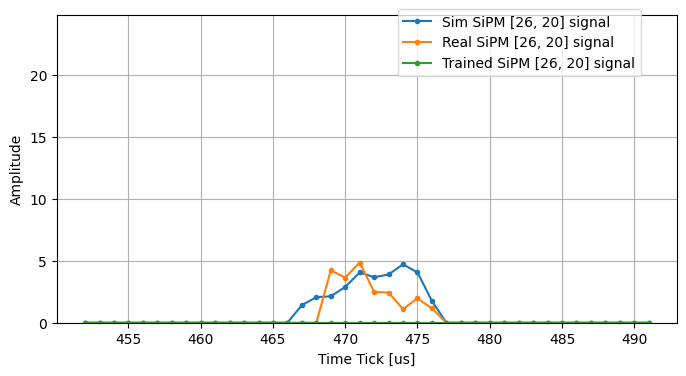

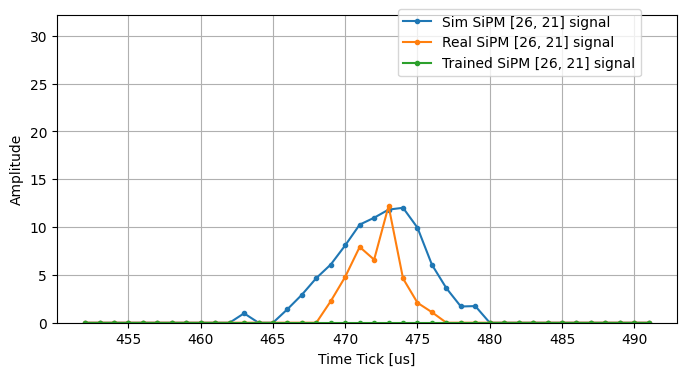

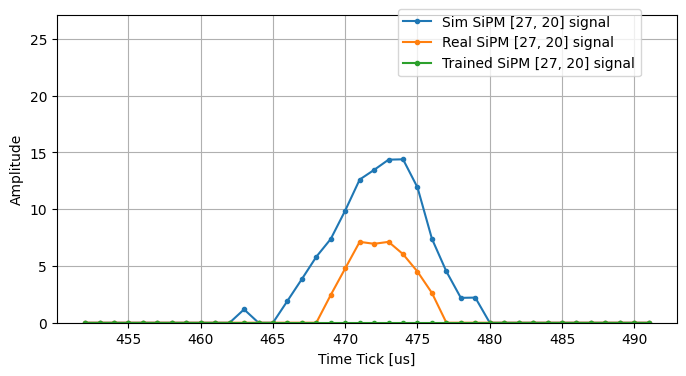

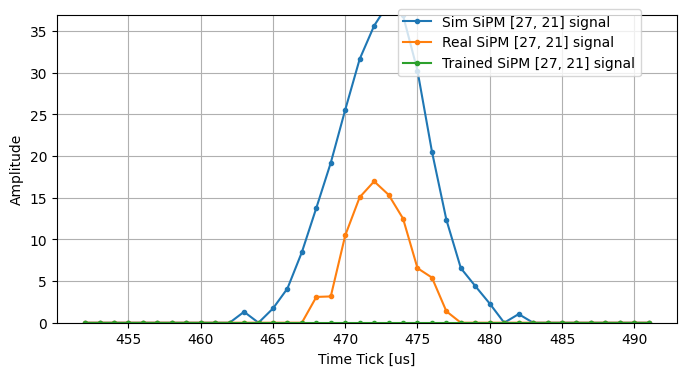

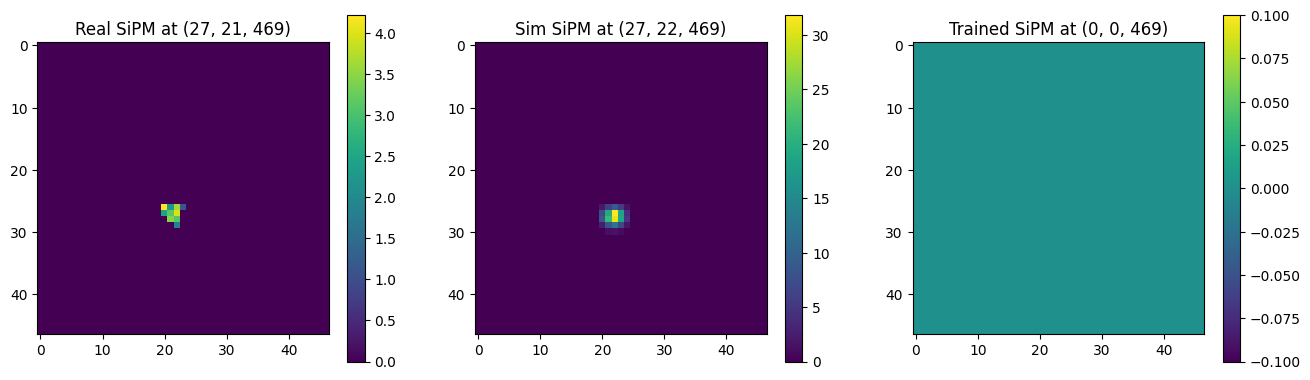

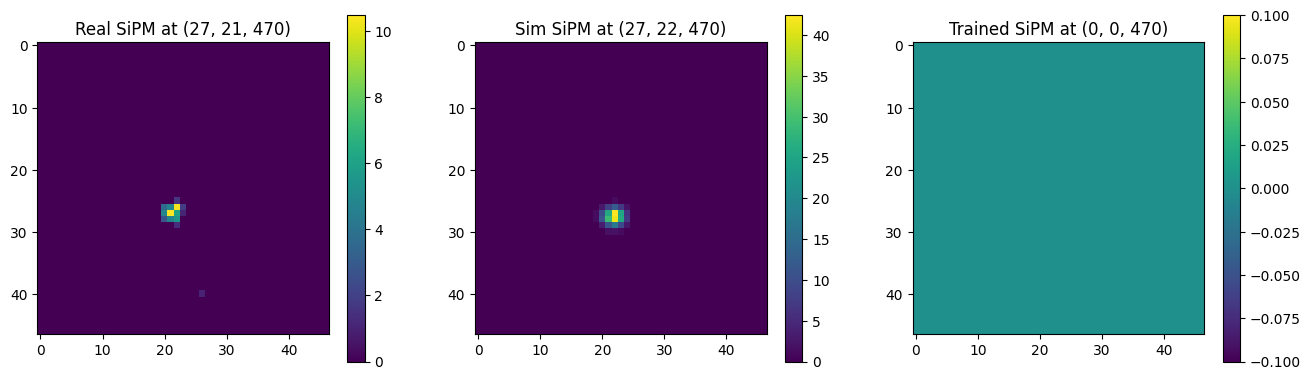

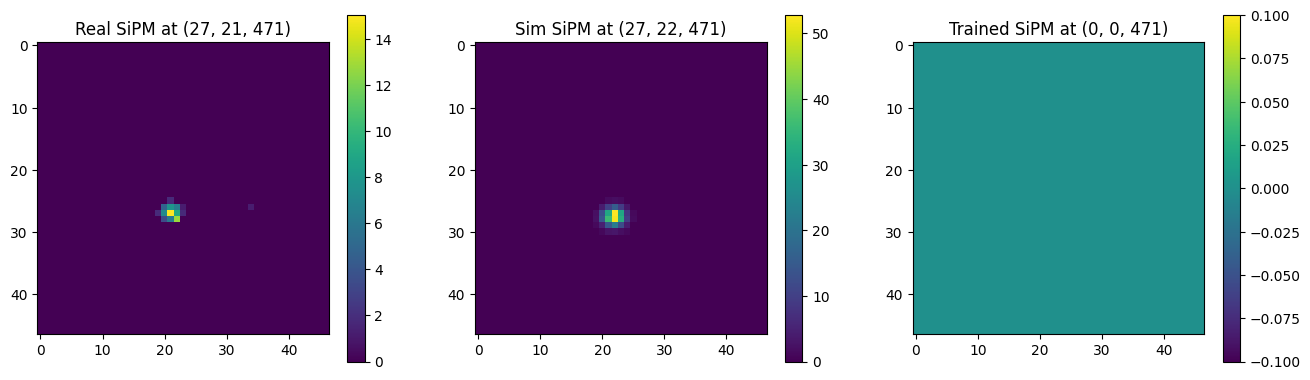

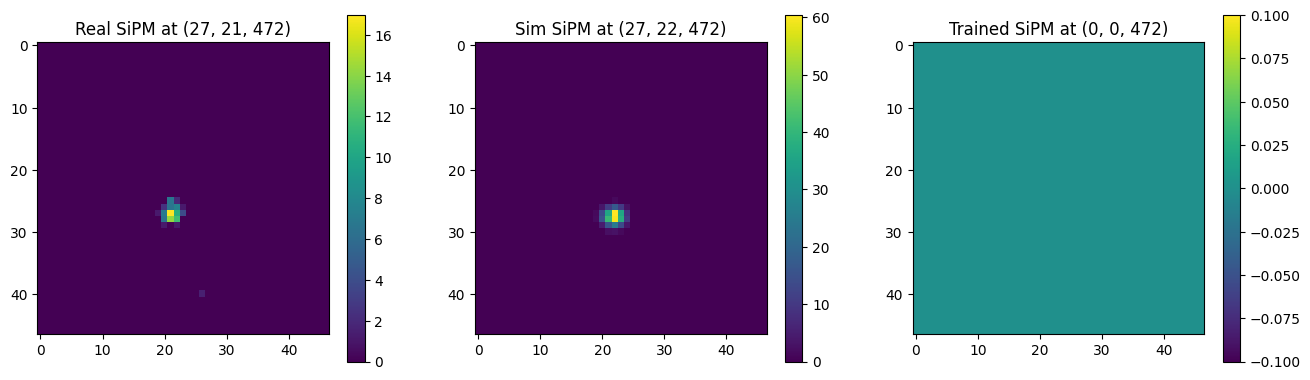

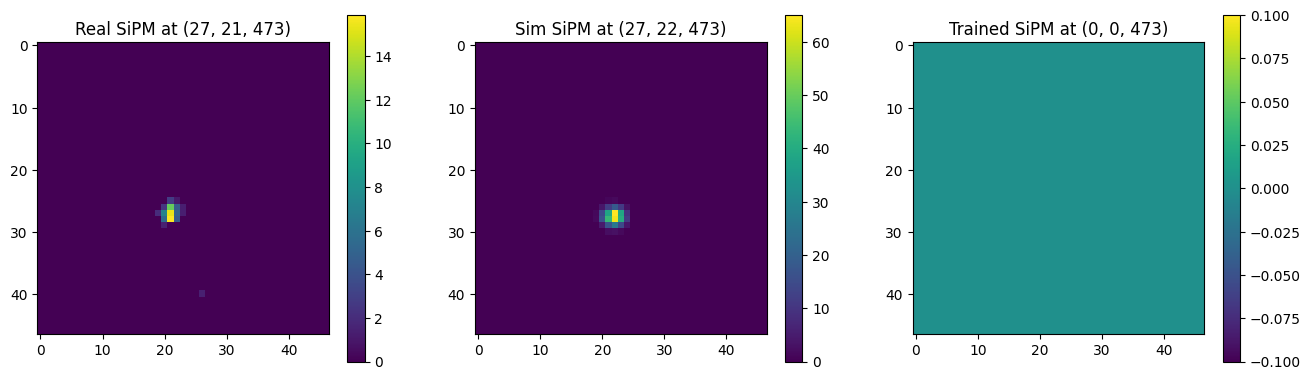

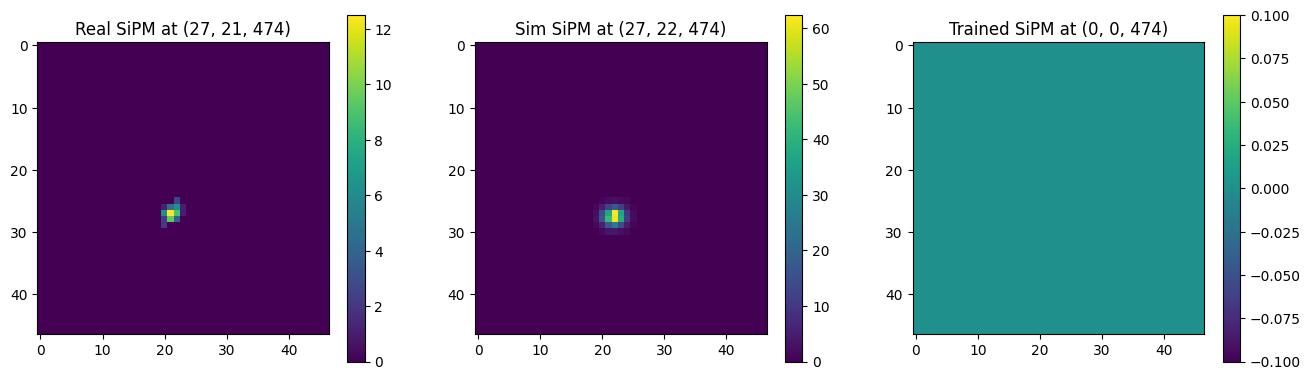

In [42]:
n = np.random.randint(0,len(batch_real['S2Si'])) 
print(n)

plot_error('SiPM',sim_pmt[n],np.zeros(shape = sim_pmt[n].shape),batch_real['S2Pmt'][n],
           sim_sipm[n],np.zeros(shape = sim_sipm[n].shape),
               batch_real['S2Si'][n])
plt.show()

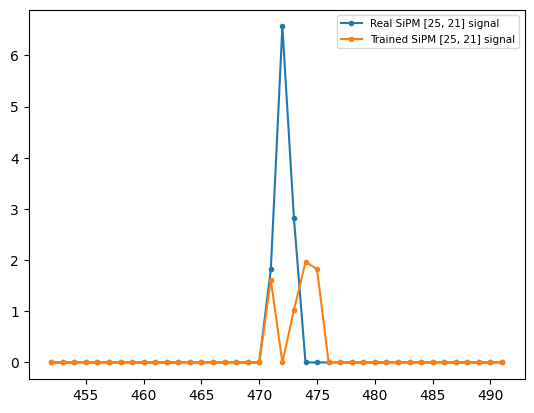

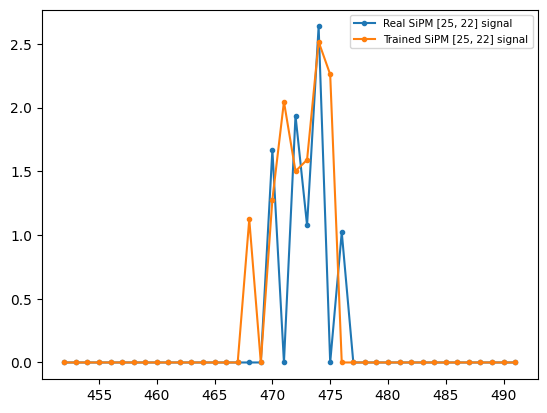

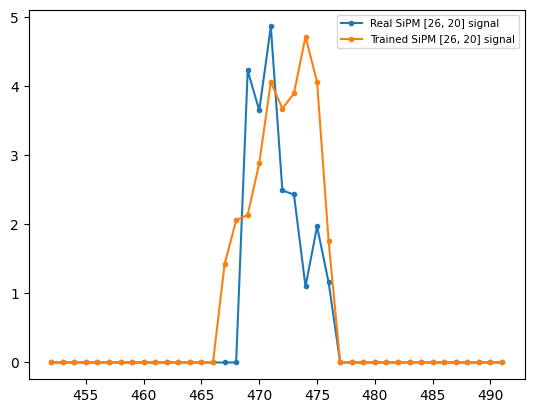

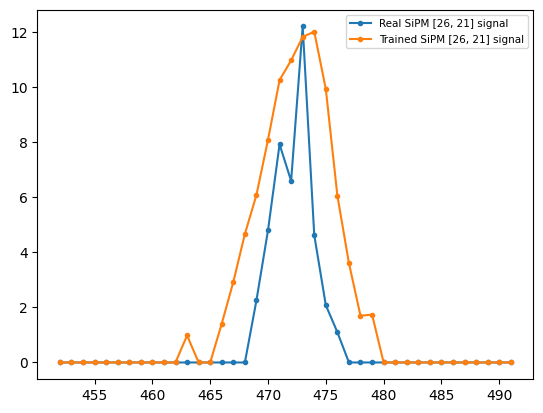

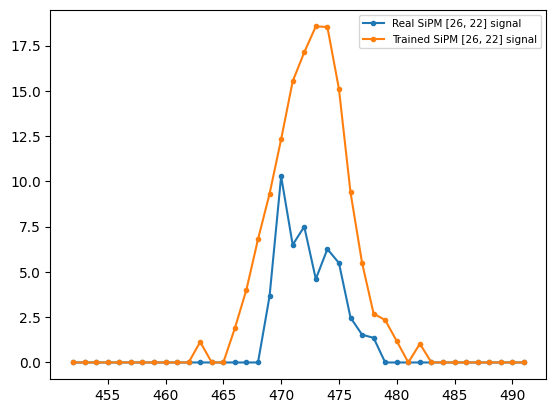

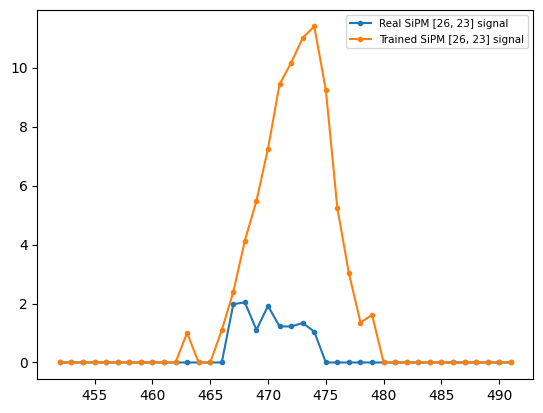

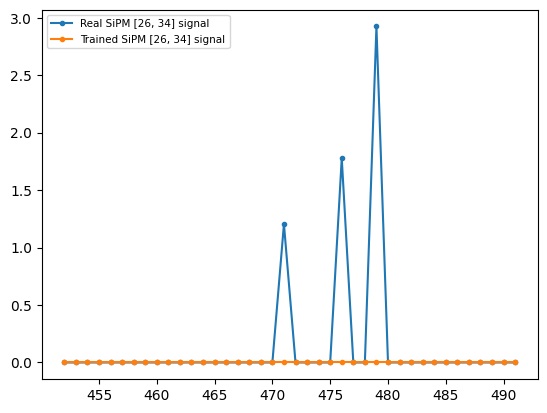

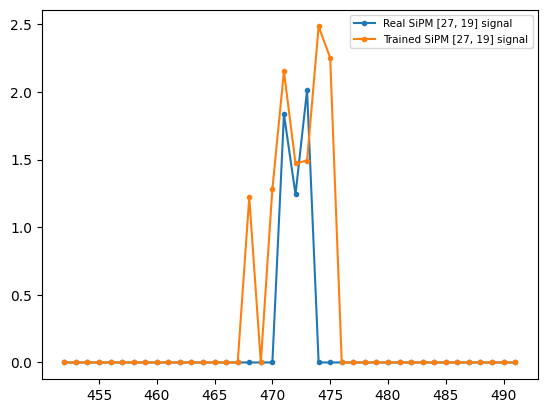

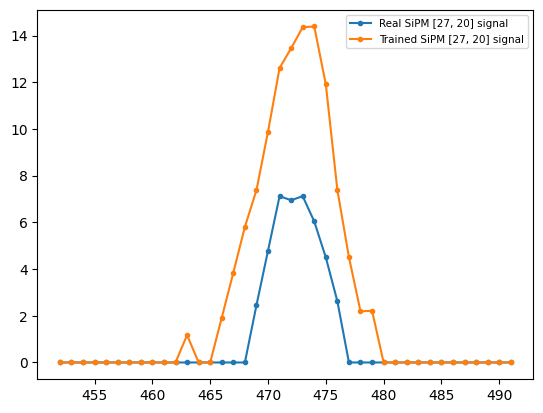

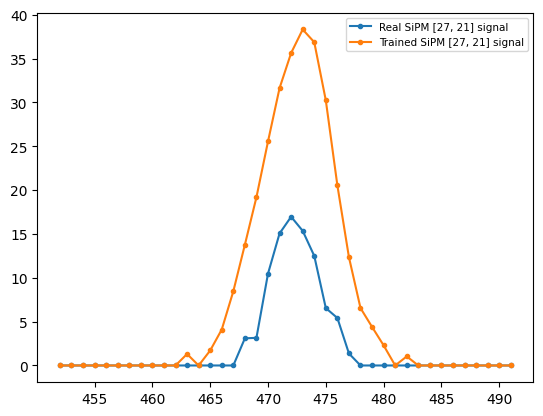

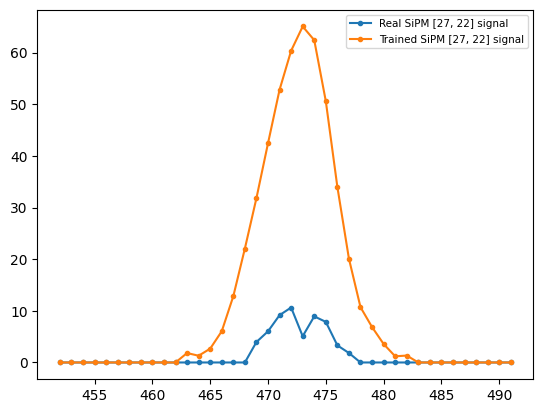

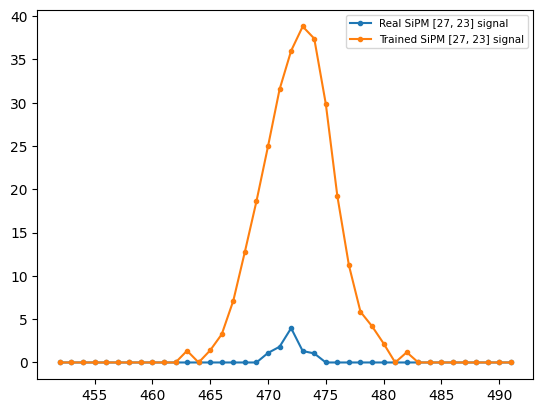

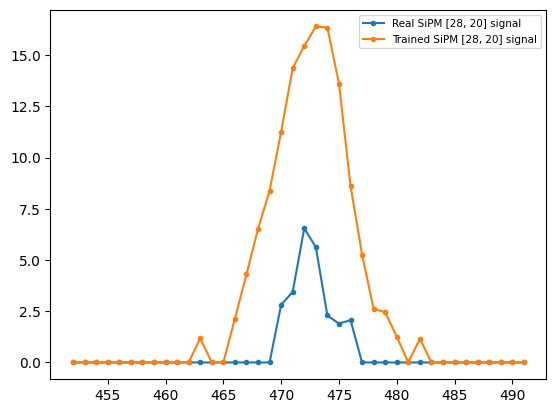

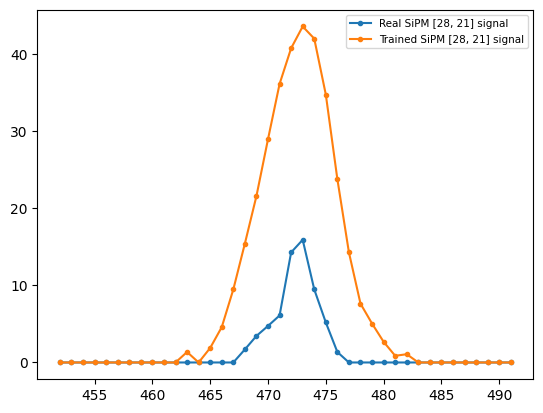

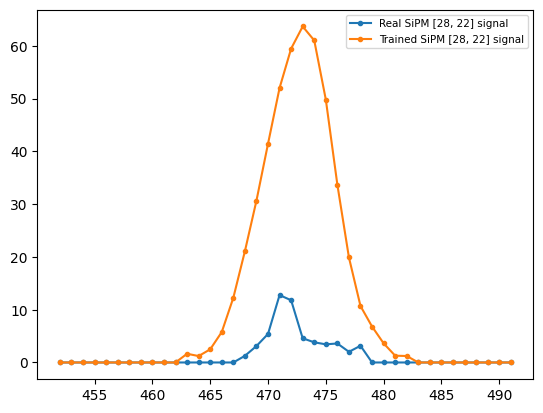

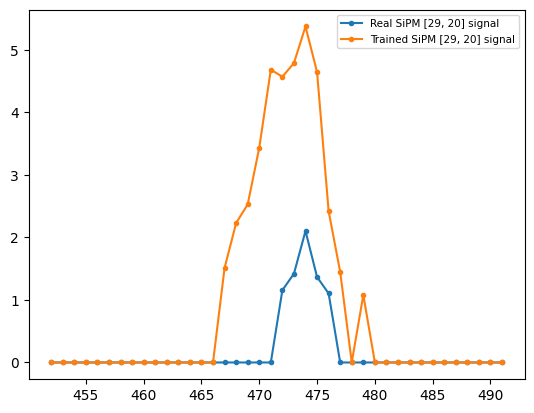

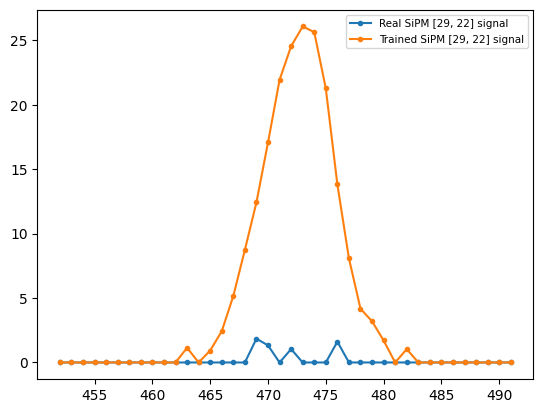

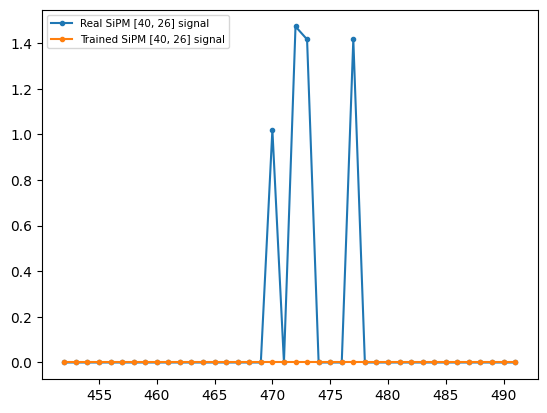

In [43]:
max_value = np.max(batch_real['S2Si'][n])
max_x, max_y, max_z = np.unravel_index(np.argmax(batch_real['S2Si'][n]), 
                                       batch_real['S2Si'][n].shape)

for i_x in range(0,47):
    for i_y in range(0,47):
            
        if len(np.unique(batch_real['S2Si'][n][i_x,i_y])) != 1:

            start = max_z - 20
            end = max_z + 20
            x_ticks = np.arange(550)

            plt.plot(x_ticks[start:end], batch_real['S2Si'][n][i_x,i_y][start:end],
                               label=f"Real SiPM [{i_x}, {i_y}] signal",marker='.')
        
            plt.plot(x_ticks[start:end],sim_sipm [n][i_x,i_y][start:end],
                                   label=f"Trained SiPM [{i_x}, {i_y}] signal",marker='.')
            plt.legend(fontsize=7.5)
        plt.show()